In [272]:
fociID = input()

0C


In [273]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
celldf = pd.read_csv('/Volumes/Kikuchi-SSD/150701F3-muNS-Per2/F3-muNS-30deg-M9glycas-0.2mMIPTG1h-bin2-TxRed300-GFP500-1minint_1/results/Results_pos%s.xls' %fociID,sep='\t')

In [274]:
celldf  = celldf.drop('Mean',1)
celldf = celldf.drop('X',1)
celldf = celldf.drop('Y',1)
celldf = celldf.drop('Perim.',1)
celldf = celldf.drop('Major',1)
celldf = celldf.drop('Minor',1)
#celldf.head(3)



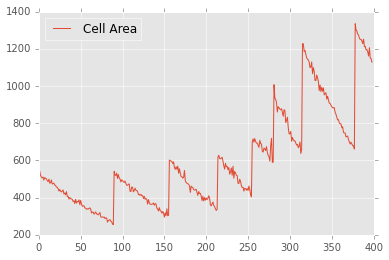

In [275]:
revcell = celldf.sort(ascending = 1)
revcell.Area.plot(label = 'Cell Area').legend(loc='upper left')

In [276]:
focidf = pd.read_csv('/Volumes/Kikuchi-SSD/150701F3-muNS-Per2/F3-muNS-30deg-M9glycas-0.2mMIPTG1h-bin2-TxRed300-GFP500-1minint_1/FociResults/FociResults_Pos%s.xls'%fociID,sep='\t')


focidf = focidf.drop('Label', 1)
focidf = focidf.drop('Min', 1)
focidf = focidf.drop('Max', 1)
focidf = focidf.drop('Slice', 1)
focidf = focidf.drop(399) #the cell ROI data lacks the first slice, so delete it here to match


cellfocidisp = ((celldf.XM-focidf.XM)**2+(celldf.YM-focidf.YM)**2)**(1/2) 

#cellfocidisp.plot(label = 'Distance between Cell Center and Foci').legend(loc='upper left', bbox_to_anchor=(1, 0.5))

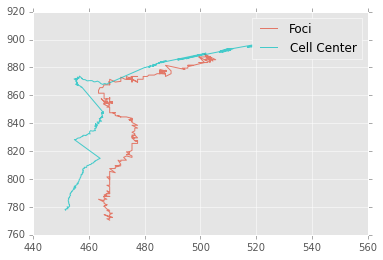

In [277]:
plt.figure();
plt.plot(focidf.XM, focidf.YM, alpha = 0.7, label = 'Foci')
plt.plot(celldf.XM, celldf.YM, 'c-', alpha = 0.7, label = 'Cell Center')
plt.legend()

In [278]:
rad = np.radians(celldf['Angle']) #convert cell ROI long axis angle to radians

radfoci = rad-np.arctan2(focidf['YM'],focidf['XM']) #convert foci polar coordinate theta taking into account the ROI's angle

polardisp= pd.Series((cellfocidisp[i+1]**2+cellfocidisp[i]**2-2*cellfocidisp[i]*cellfocidisp[i+1]*np.cos(radfoci[i+1]-radfoci[i]))**(1/2) for i in range (len(cellfocidisp)-1))

#polardisp.plot(label = 'Polar Displacement').legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [279]:
focix = focidf['XM']
fociy = focidf['YM']
cartdisp = pd.Series(((focix[i+1]-focix[i])**2+(fociy[i+1]-fociy[i])**2)**(1/2) for i in range (len(focix)-1))
#cartdisp.plot(label = 'Cartesian Displacement').legend(loc='center left', bbox_to_anchor=(1, 0.5))

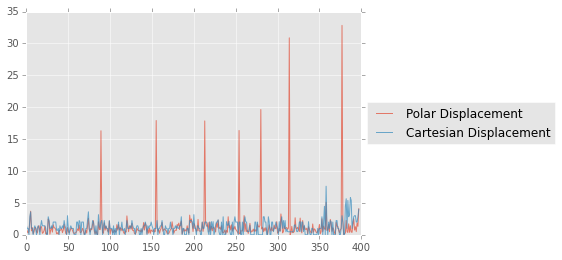

In [280]:
plt.figure();

polardisp.plot(label = 'Polar Displacement', alpha = 0.7)
cartdisp.plot( label = 'Cartesian Displacement', alpha = 0.7)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#celldf.Area.plot(ax = ax2, color = '#E8D66F', label = 'Cell Area',  alpha = 0.7)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113918748>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x113ad6b00>]], dtype=object)

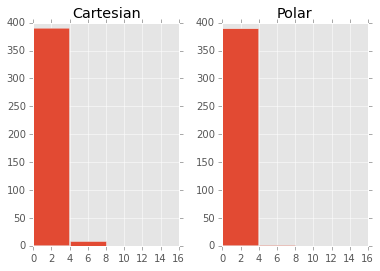

In [281]:
dispdf = pd.DataFrame({'Cartesian': cartdisp, 'Polar': polardisp})
#dispdf.head(3)

plt.figure();
dispdf.hist(bins=[0,4,8,12,16])

In [235]:
celldf['Foci X'] = focix
celldf['Foci Y'] = fociy
celldf['r'] = cellfocidisp
celldf['theta'] = radfoci
celldf['Cartesian Displacement'] = cartdisp
celldf['Polar Displacement'] = polardisp
celldf.to_csv('/Volumes/Kikuchi-SSD/150701F3-muNS-Per2/F3-muNS-30deg-M9glycas-0.2mMIPTG1h-bin2-TxRed300-GFP500-1minint_1/Python_Processed/data_pos%s.csv'%fociID, sep=',')

In [111]:
celldf.head(2)

,,Label,Area,XM,YM,Angle,Foci X,Foci Y,r,theta,Cartesian Displacement,Polar Displacement
0,1,Binarized:0400-0100-0298:Pos00399,173,298.321,99.801,75.078,293.5,119.5,20.280351,0.923699,8.485281,5.612189
1,2,Binarized:0399-0100-0298:Pos00398,163,298.046,98.666,78.998,299.5,113.5,14.905089,1.016533,4.000000,3.180453


### 150909BossDiscussion
- Check relation of foci displacement and cell size. Larger cells mean that the foci would appear to move longer compared to that within smaller cells.
- Per-frame cell size and per-frame foci displacement correlation = linear?
- Fit cell elongation with a exponential function and obtain smoothed cell size
- Compare two distinct foci within cells with same size: will their displacement differ?


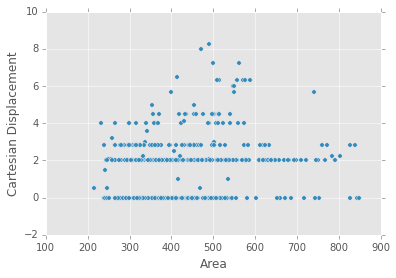

In [223]:
celldf.plot(kind='scatter', x='Area', y='Cartesian Displacement');

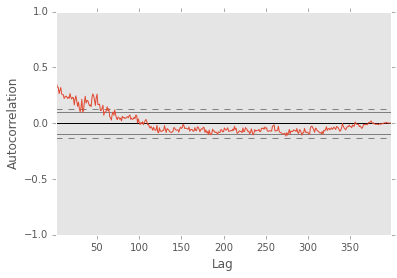

In [256]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(cartdisp)